# 548 hw4 solution

# linear-quadratic regulation

***Purpose:***  *control a nonlinear system near an equilibrium by linearizing and applying the infinite-horizon linear-quadratic regulator.*

Consider the continuous-time nonlinear system (NL) from HW2 that models a pendulum:

$$m \ell^2 \ddot{q} + m g \ell \sin q = \ell u - \ell b \dot{q}.$$

Recall from HW3 that choosing $x = (q,\dot{q})$ and linearizing (NL) about the unstable equilibrium $(x_0, u_0) = ((\pi,0), 0)$ yields the unstable continuous-time linear time-invariant system (LTI)

$$ \delta \dot{x} = A \delta x + B \delta u,\ A 
= 
\left[\begin{array}{c} 0 &  1\\ \frac{g}{\ell} &  -\frac{b}{m\ell} \end{array}\right],\ B = \left[\begin{array}{c} 0 \\ \frac{1}{m\ell} \end{array}\right].$$

Use parameter values $m = 1\ \text{kg}$, $\ell = 1\ \text{m}$, $g = 10\ \text{m/sec}^2$, $b = 1$, in the following problems.

(a) *Implement an algorithm that solves the continuous-time linear-quadratic regulation (CT-LQR) problem for (LTI) with the infinite-horizon cost function*
$$ \frac{1}{2} \int_0^\infty q\, \delta x_t^\top \delta x_t + r\, \delta u_t^\top \delta u_t\, dt $$
*to obtain $K$ such that $\delta u^* = - K \delta x$ is the optimal input to apply when the state of (LTI) is $\delta x$.*

***Hint:*** it is possible to solve this problem symbolically (e.g. using `SymPy` to solve the Riccati equation -- be careful to ensure the $P$ solution you choose is positive-definite!) or numerically (e.g. by simulating the Riccati DE backward in time on a long time horizon -- be careful to ensure the time horizon is long enough!).  Or, if you want a one-liner, you can find and use a computational tool.

(b) *Fix $r = 1$ and plot the entries of $K$ as a function of the ratio $q / r$ over a range that includes $q = r = 1$; describe the trend you observe in the graph in practical terms -- recall that $q$ quantifies the cost of "error" and $r$ quantifies the cost of "effort".*

(c) *Fix $r = 1$ and plot the real part of the eigenvalues of the closed-loop system matrix $A - B K$ as a function of the ratio $q / r$ over a range that includes $q = r = 1$; what property does the closed-loop system have?*

(d) *Simulate the closed-loop dynamics for (LTI) twice:  once with $q \gg r$ and once with $q \ll r$, and provide plots illustrating the results; describe the difference you observe in the two cases with reference to your explanation in (b).*

(e) *Simulate the closed-loop dynamics for (NL) twice:  once with $q \gg r$ and once with $q \ll r$, and provide plots illustrating the results; how does the result compare with your result in (d)?*


***Note:*** the solution to this problem is more interesting if $Q = \left[\begin{array}{c} q &  0\\ 0 & 0 \end{array}\right]$ rather than $Q = q I$ as in the statement above -- the solution below will focus on this "more interesting" case, but you can obtain the solution to the "less interesting" case by swapping out one line of code that will be highlighted below.

## (a) solution

In [1]:
import sympy as sym

m,l,g,b = sym.symbols(r'm, \ell, g, b')

A = sym.Matrix([[0,1],[g/l,-b/(m*l)]])
B = sym.Matrix([[0],[1/(m*l)]])

q,r = sym.symbols(r'q, r',real=True,positive=True)



Matrix([[(sqrt(r)*sqrt(q + 100*r) + 10*r)/r, (-r + sqrt(q*r + 2*r**(3/2)*sqrt(q + 100*r) + 21*r**2))/r]])

In [2]:
# less interesting
Q = q*sym.Matrix.eye(2)

In [3]:
# more interesting
Q = q*sym.Matrix([[1,0],[0,0]])

In [4]:
R = r*sym.Matrix.eye(1)

P1,P12,P2 = sym.symbols(r'P_1, P_{12}, P_2',real=True,positive=True)

P = sym.Matrix([[P1,P12],[P12,P2]])

# note:  there is only one positive-definite solution
sol = sym.solve(A.T @ P + P @ A - P @ B @ R.inv() @ B.T @ P + Q,P)[3]
P_ = P.subs({P1:sol[0],P12:sol[1],P2:sol[2]})

K_ = (R.inv() @ B.T @ P_).subs({m:1,l:1,g:10,b:1})
K_

Matrix([[(sqrt(r)*sqrt(q + 100*r) + 10*r)/r, (-r + sqrt(2*r**(3/2)*sqrt(q + 100*r) + 21*r**2))/r]])

## (b) solution

In [5]:
_K = sym.lambdify(q,K_.subs({r:1}))

In [6]:
import numpy as np

o = np.logspace(-1,5)
Ko = np.vstack([_K(_o) for _o in o])

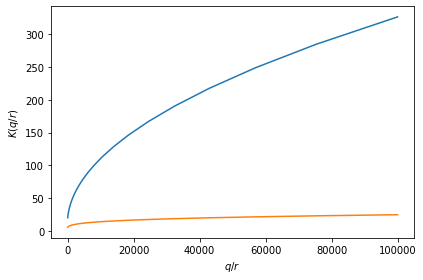

In [7]:
import pylab as plt

plt.plot(o,Ko)
plt.xlabel(r'$q/r$')
plt.ylabel(r'$K(q/r)$')

plt.tight_layout()

## (c) solution



In [8]:
A_BK = (A - B @ K_).subs({m:1,l:1,g:10,b:1})
_A_BK = sym.lambdify(q,A_BK.subs({r:1}))

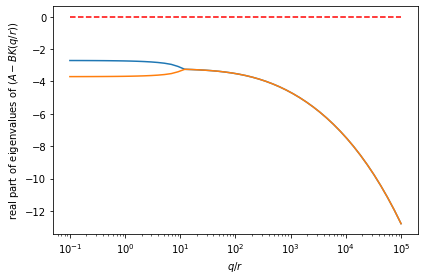

In [9]:
e = np.vstack([np.linalg.eigvals(_A_BK(_o)) for _o in o])

plt.semilogx(o,e.real)
plt.semilogx(o[[0,-1]],[0,0],'r--')
plt.xlabel(r'$q/r$')
plt.ylabel(r'real part of eigenvalues of $(A - B K(q/r))$')

plt.tight_layout()

Since eigenvalues always have negative real part, the closed-loop system is stable for any choice of ratio $q/r$.

In [10]:
def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

## (d) solution

Based on the plot of the eigenvalues as a function of the ratio from (c), it looks like $q/r = 1$ and $q/r = 1000$ give significantly different results that capture the qualitative differences.

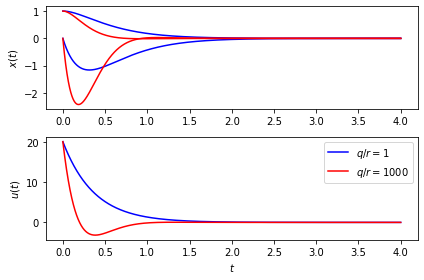

In [60]:
_A_ = np.asarray(A.subs({m:1,l:1,g:10,b:1}),dtype=np.float)
_B_ = np.asarray(B.subs({m:1,l:1,g:10,b:1}),dtype=np.float)

t = 4
x0 = [1,0]

def LTI(t,x,_K_):
  u = -np.dot(x, _K_.T)
  dx = np.dot(x,_A_.T) + np.dot(u,_B_.T)
  return dx

q_r = 1
t_,x_1 = numerical_simulation(lambda t,x : LTI(t,x,_K(q_r)),t,x0)
u_1 = np.dot(x_1,_K_.T)

q_r = 1000
t_,x_1000 = numerical_simulation(lambda t,x : LTI(t,x,_K(q_r)),t,x0)
u_1000 = np.dot(x_1000,_K_.T)

plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,x_1,'b',label=r'$q/r = 1$')
plt.plot(t_,x_1000,'r',label=r'$q/r = 1000$')
plt.ylabel(r'$x(t)$')

plt.subplot(2,1,2)
plt.plot(t_,u_1,'b',label=r'$q/r = 1$')
plt.plot(t_,u_1000,'r',label=r'$q/r = 1000$')
plt.ylabel(r'$u(t)$')
plt.xlabel(r'$t$')
plt.legend()

plt.tight_layout()

## (e) solution

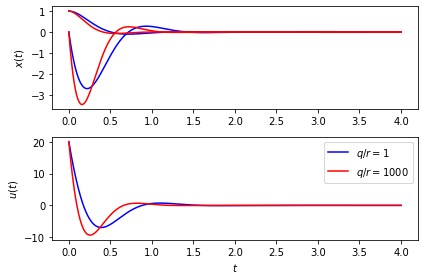

In [61]:
t = 4
x0 = [1,0]
  
def NL(t,x,_K_,m=1,l=1,g=10,b=1):
  u = -np.dot(x, _K_.T)
  q, v = x[0], x[1] 
  return np.hstack([v, (1/(m * l)) * (u - (b * v) - (m * g * np.sin(q)))])

q_r = 1
t_,x_1 = numerical_simulation(lambda t,x : NL(t,x,_K(q_r)),t,x0)
u_1 = np.dot(x_1,_K_.T)

q_r = 1000
t_,x_1000 = numerical_simulation(lambda t,x : NL(t,x,_K(q_r)),t,x0)
u_1000 = np.dot(x_1000,_K_.T)

plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,x_1,'b',label=r'$q/r = 1$')
plt.plot(t_,x_1000,'r',label=r'$q/r = 1000$')
plt.ylabel(r'$x(t)$')

plt.subplot(2,1,2)
plt.plot(t_,u_1,'b',label=r'$q/r = 1$')
plt.plot(t_,u_1000,'r',label=r'$q/r = 1000$')
plt.ylabel(r'$u(t)$')
plt.xlabel(r'$t$')
plt.legend()

plt.tight_layout()